In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

**Business Questions:**
- How many customers were there for each approach?
- What does the spread of the revenue look like overall? And for each method?
- Was there any difference in revenue over time for each of the methods?
- Based on the data, which method would you recommend we continue to use? Some of these methods take more time from the team so they may not be the best for us to use if the results are similar.

**Notes:** We don’t really know if there are other differences between the customers in each group, so anything you can tell us would be really helpful to give some context to what went well.

**Data-set from the Sale Department.** 
The data only relates to the new products sold. As there are multiple different products, the revenue will vary depending on which products were sold.
The data hasn't been validated. 

**Below are the details of the data-set.**

| Column Name         | Details                                                                                      |
|---------------------|----------------------------------------------------------------------------------------------|
| week                | Week sale was made, counted as weeks since product launch                                    |
| sales_method        | Character, which of the three sales methods were used for that customer                      |
| customer_id         | Character, unique identifier for the customer                                                |
| nb_sold             | Numeric, number of new products sold                                                         |
| revenue             | Numeric, revenue from the sales, rounded to 2 decimal places                                 |
| years_as_customer   | Numeric, number of years customer has been buying from us (company founded in 1984)          |
| nb_site_visits      | Numeric, number of times the customer has visited our website in the last 6 months           |
| state               | Character, location of the customer i.e., where orders are shipped                           |


#### Data Cleaning Process

#### 1. **Data Inspection**
   - The dataset contains 15,000 entries and 8 columns.
   - **Data types:** All data types appear correct. The "week" and "state" columns are of type `object`, while the remaining columns are numeric.
   - **Null values:** `1,074` Null values were found in revenue colum, as verified using the `df.info()` `df.isnull().sum()`method.
   - **Data Entries Consistency:** Checking the sales method, it shows that entry names are not consistent. For instance, variations like `email`, `Email`, and `em` are used to indicate the `Email` sales method.

   - **Solution:** Revenue depends on the type of product as well as the number of items sold. Since we do not have information about the product type, imputing missing values using the mean or median is not feasible, as it could oversimplify the data. Additionally, with only `1,074` `NaN` values (`544` out of `7,466` for the `email` method, `349` out of `4,982` for the `call` method, and `181` out of `2,572` for `email+call` method), I decided to remove the rows where revenue is missing, as this approach will not significantly impact the dataset size.

   - **Data set:** The clean dataset contains 13,926 records and 8 columns. 
  

#### 2. **Checking Duplicates**
   - **Duplicates:** No duplicate rows were detected in the dataset, as verified by the `df.duplicated()` method.


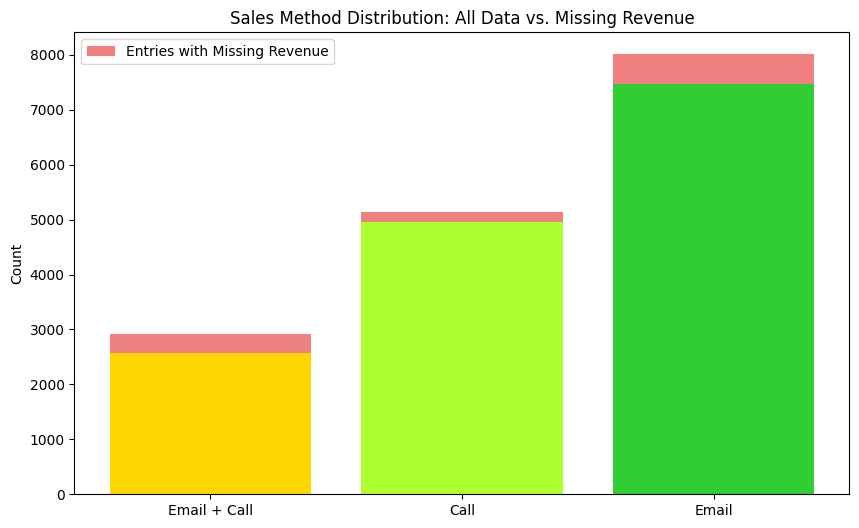

In [130]:
# **Data Inspection**

df = pd.read_csv('./data/product_sales.csv')
#print(df.info())
#print(df.isnull().sum())
df['sales_method'].value_counts()

df['sales_method'] = df['sales_method'].str.strip()
df['sales_method'] = df['sales_method'].str.title()
given_names = list(df['sales_method'].unique())

df['sales_method'] = df['sales_method'].replace({given_names[3]: given_names[1]})
with_null = df['sales_method'].value_counts()

missing_revenues = df[df['revenue'].isnull()]['sales_method'].value_counts()


color_code = {'Email + Call': '#FFD700', "Call": '#ADFF2F', "Email": '#32CD32'}
custom_palette = list(color_code.values())

with_null = with_null.reindex(color_code.keys())
missing_revenues = missing_revenues.reindex(color_code.keys())

plt.figure(figsize=(10, 6))
plt.bar(with_null.index, with_null, color=custom_palette)
plt.bar(missing_revenues.index, missing_revenues, bottom=with_null, label='Entries with Missing Revenue', color='lightcoral')

plt.title('Sales Method Distribution: All Data vs. Missing Revenue')
plt.xlabel('')
plt.ylabel('Count')
plt.legend()
plt.show()



#### 1. Customer Segmentation Analysis:
- How many unique customers were there for each of the three sales methods? 
- Are there any significant differences in the number of customers for each sales method?

- **Insights:** The email and call combination has the fewest customers, with 2,223—half the number of customers from calls alone. Email, the highest-engagement method, draws 2,000 more customers than calls, representing a 33% higher engagement than the call alone.

(13926, 8)
(13926, 8)


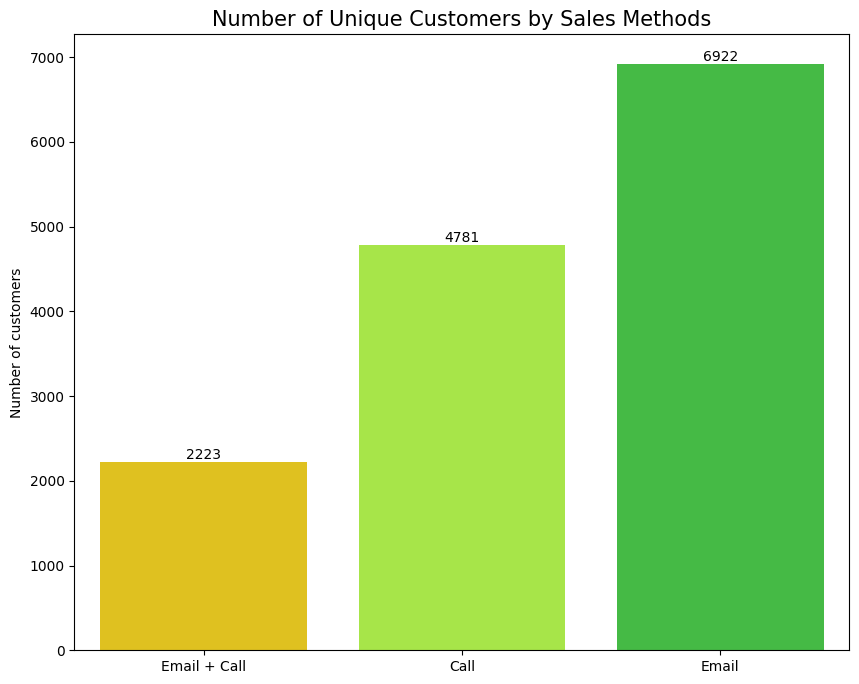

In [131]:
df_clean = df.dropna(subset=['revenue'])
print(df_clean.shape)
df_clean.duplicated(subset='customer_id')
df_customers = df_clean.drop_duplicates(subset='customer_id')
print(df_customers.shape)
cus_segmenation = df_customers['sales_method'].value_counts().reset_index()
cus_segmenation = cus_segmenation.sort_values(by = "count")

plt.figure(figsize=(10, 8))
ax = sns.barplot(cus_segmenation, x="sales_method", y="count", errorbar=None, hue = "sales_method", palette = custom_palette)
for k in range(len(ax.containers)):
    ax.bar_label(ax.containers[k], fontsize=10)

plt.title('Number of Unique Customers by Sales Methods', fontsize = 15)
plt.xlabel('')
plt.ylabel('Number of customers')
plt.show()



#### 2. Revenue Distribution Analysis:
- What is the overall distribution of revenue for all customers, and how does it differ by sales method?
- Are there any outliers in revenue for any sales method? 
- Based on the revenue data, which sales method generates the highest average revenue per customer?

**Insights** 
- Overall, most of the sales are relatively low, with 75% of the sales having a revenue of 107 or less. The lowest sale is 32.54, and the highest sale is 238.
- The `Email-only method` generates the highest total revenue, but the `Email and Call` combination produces the highest average revenue per customer at 183.65. The `Email-only` method has an average of 97.13, while `Call-only` has the lowest average at 47.60.
- The `Email and Call` combination also shows the most variation in sales, but there are no extreme values. However, `Email` has 87 cases with unusually high sales, and `Call` has 12, though the overall range of sales remains relatively narrow for both.
- Based on the revenue data, `Email and Call` combination method generates the **highest average revenue per customer**.  
- In general, it can be assumed that the `Email and Call` method takes longer than both the `Email-only` and `Call-only` methods. However, given the significantly higher revenue it generates—**twice as much as the Email-only method** and nearly **four times as much as the Call-only method**—this method should be recommended

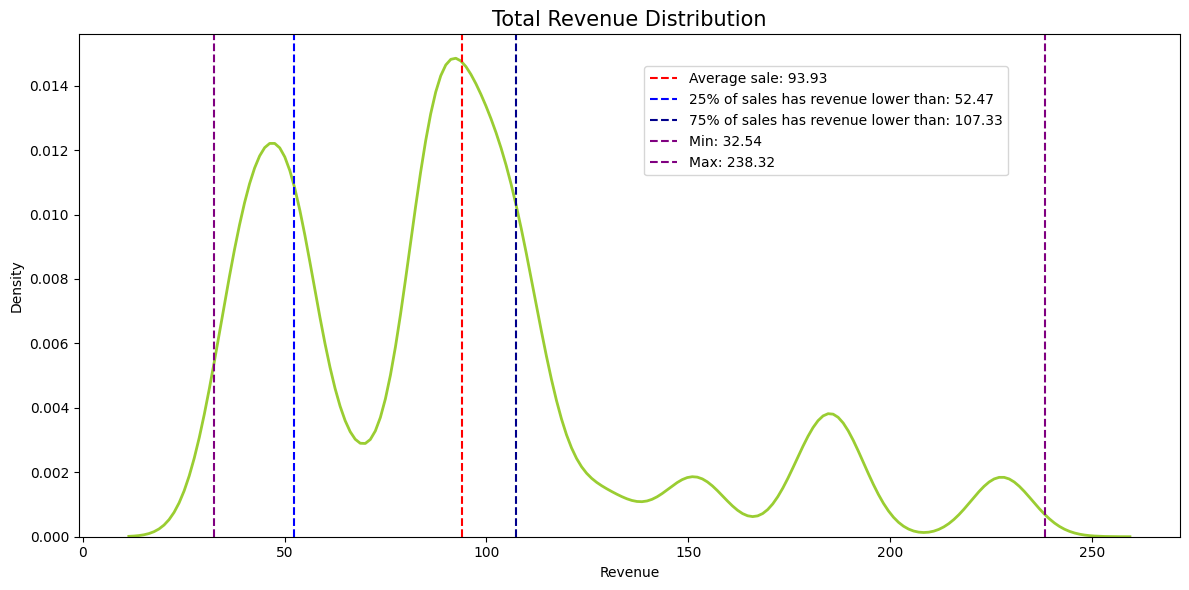

In [132]:
mean_revenue = df_clean['revenue'].mean()
Q1 = df_clean['revenue'].quantile(0.25)
Q3 = df_clean['revenue'].quantile(0.75)
range_revenue = df_clean['revenue'].max() - df_clean['revenue'].min()

plt.figure(figsize=(12, 6))
sns.kdeplot(df_clean['revenue'], color='yellowgreen', linewidth=2)

plt.axvline(mean_revenue, color='red', linestyle='--', linewidth=1.5, label=f'Average sale: {mean_revenue:.2f}')
plt.axvline(Q1, color='blue', linestyle='--', linewidth=1.5, label=f'25% of sales has revenue lower than: {Q1:.2f}')
plt.axvline(Q3, color='darkblue', linestyle='--', linewidth=1.5, label=f'75% of sales has revenue lower than: {Q3:.2f}')
plt.axvline(df_clean['revenue'].min(), color='purple', linestyle='--', linewidth=1.5, label=f'Min: {df_clean['revenue'].min():.2f}')
plt.axvline(df_clean['revenue'].max(), color='purple', linestyle='--', linewidth=1.5, label=f'Max: {df_clean['revenue'].max():.2f}')

plt.title('Total Revenue Distribution', fontsize=15)
plt.xlabel('Revenue')
plt.ylabel('Density')
plt.legend(loc='upper right', bbox_to_anchor=(0.85,0.95))
plt.tight_layout()
plt.show()


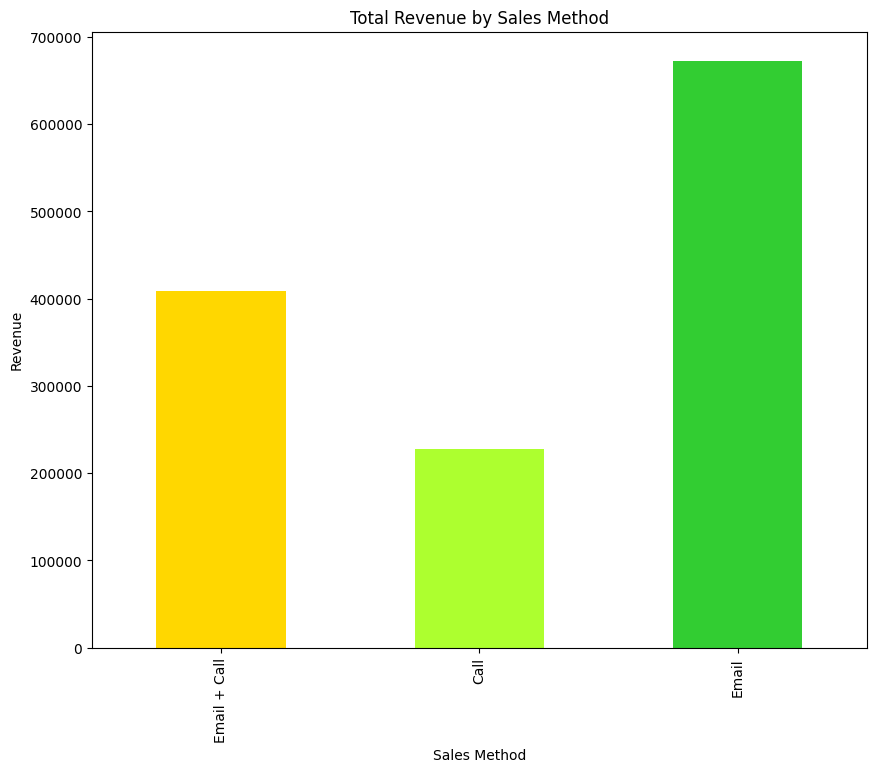

In [133]:
ordered_methods = color_code.keys()

df_total_revenue = df_clean.groupby('sales_method')['revenue'].sum().reindex(ordered_methods)
plt.figure(figsize=(10, 8))
df_total_revenue.plot(kind='bar', color=custom_palette)
plt.title('Total Revenue by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Revenue')
plt.show()

{'Email + Call': 0, 'Call': 12, 'Email': 87}


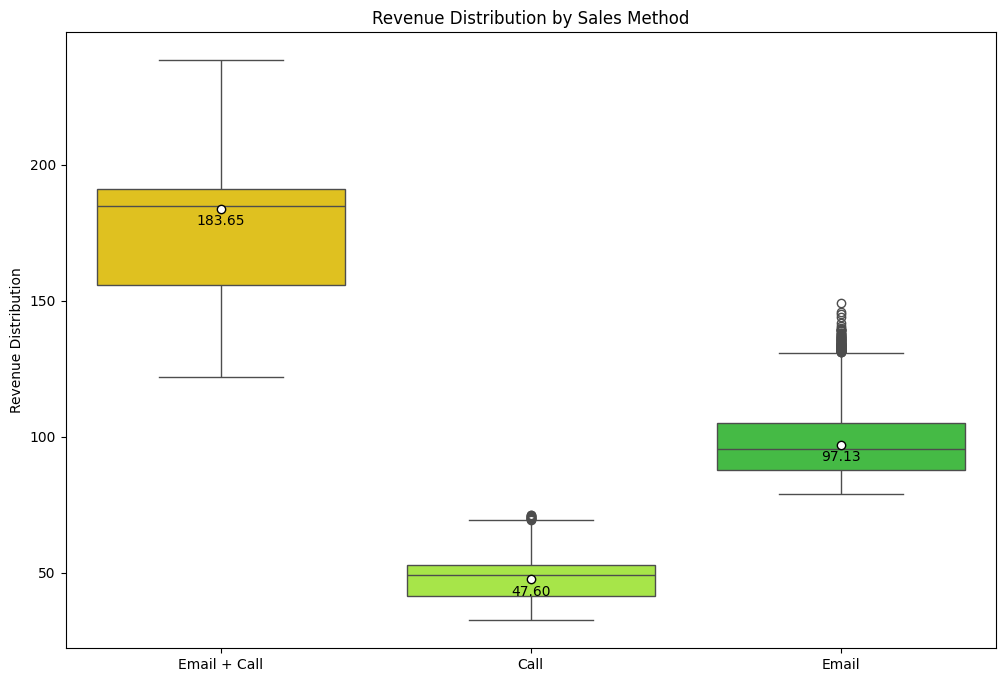

In [134]:

outliers_dict = {}
for method in ordered_methods:
    data = df_clean[df_clean['sales_method']==method]['revenue']
    lower_bound = data.quantile(0.25) - 1.5*(data.quantile(0.75) - data.quantile(0.25))
    uppper_bound = data.quantile(0.75) + 1.5*(data.quantile(0.75) - data.quantile(0.25))
    outliers = data[(data < lower_bound) | (data > uppper_bound)]
    outliers_dict[method] = len(outliers)

print(outliers_dict)

means = df_clean.groupby('sales_method', observed=False)['revenue'].mean()
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df_clean, x='sales_method', y='revenue', hue = 'sales_method', order = ordered_methods, palette = custom_palette, 
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"})
for i, method in enumerate(ordered_methods):
    ax.text(i, means[method]-6, f'{means[method]:.2f}', color='black', ha='center', fontsize=10)
plt.title('Revenue Distribution by Sales Method', fontsize=15)
plt.xlabel('')
plt.ylabel('Revenue Distribution')
plt.title('Revenue Distribution by Sales Method')
plt.show()

#### 3. Revenue Trend Over Time:
- How does the revenue trend change over time for each of the sales methods? 
- Are there any noticeable patterns or fluctuations in revenue based on the week the sale was made?
- Does the revenue for a particular sales method increase or decrease as time progresses (i.e., week-on-week comparison)?

**Insights** - Sales increase over time, with a slight downturn observed in week 3 after the product launch, followed by a rise in week 4. The `Email+Call` combination shows a steeper upward trend after week 4 compared to the other two methods.

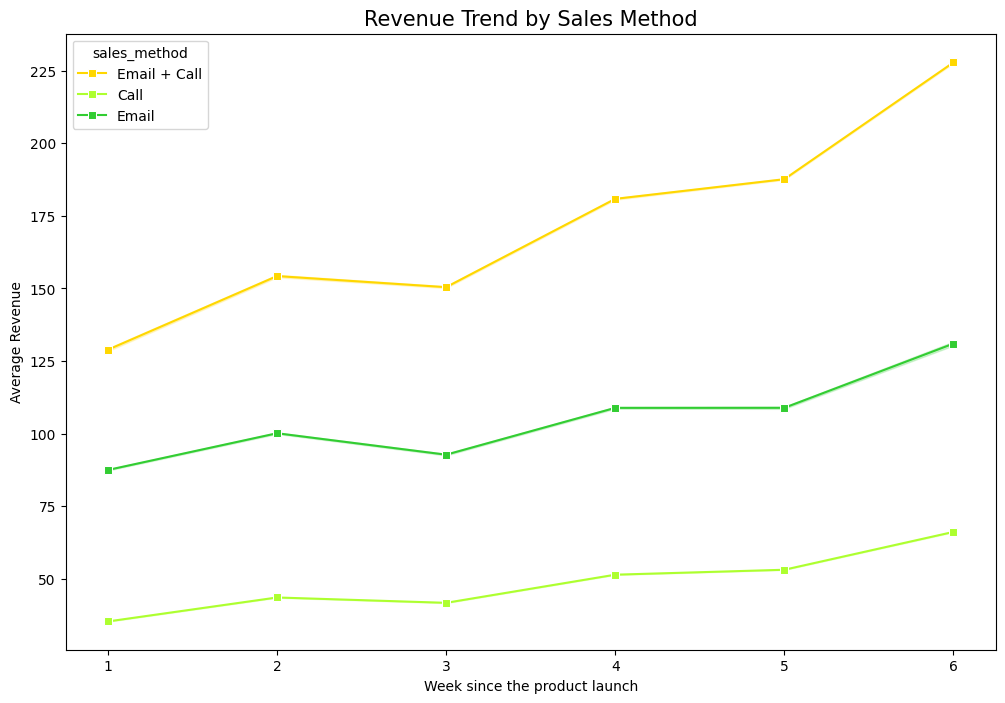

In [172]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_clean, x='week', y='revenue', hue='sales_method', marker = 's', palette=custom_palette)
plt.title('Revenue Trend by Sales Method', fontsize=15)
plt.xlabel('Week since the product launch')
plt.ylabel('Average Revenue')
plt.show()

#### 4. Customer Behavior Insights:
- Are there any significant differences in revenue for customers who have been buying from us for many years compared to newer customers? 
- How do customer behaviors such as the number of site visits or years as a customer influence the revenue?
- Is there a correlation between the number of site visits and the revenue generated by customers?

**Insights**
- There is **no significant differences** in revenue between long-time customers and newer customers. 
- However, the number of site visits does influence revenue, with a notable impact only when site visits **exceed 30**.
- The `Email and Call` combination method generates the **highest average revenue per customer** within each engagement level. 

In [176]:
bins = [0, 5, 10, df_clean['years_as_customer'].max()]
labels = ['Less than 5 years', 'Regular: 5–10 years', 'Loyal: 10+ years']
df_clean.loc[:,'customer_type'] = pd.cut(df_clean['years_as_customer'], bins=bins, labels=labels, right=False)

bins = [0, 20, 30, df_clean['nb_site_visits'].max()]
labels = ['Low: less than 20 visits', 'Moderate: between 20 and 30 visits', 'High: more than 30 visits']
df_clean.loc[:,'engagement_level'] = pd.cut(df_clean['nb_site_visits'], bins=bins, labels=labels, right=False)
df_clean.loc[:,'engagement_level'] = df_clean['engagement_level'].astype('category')


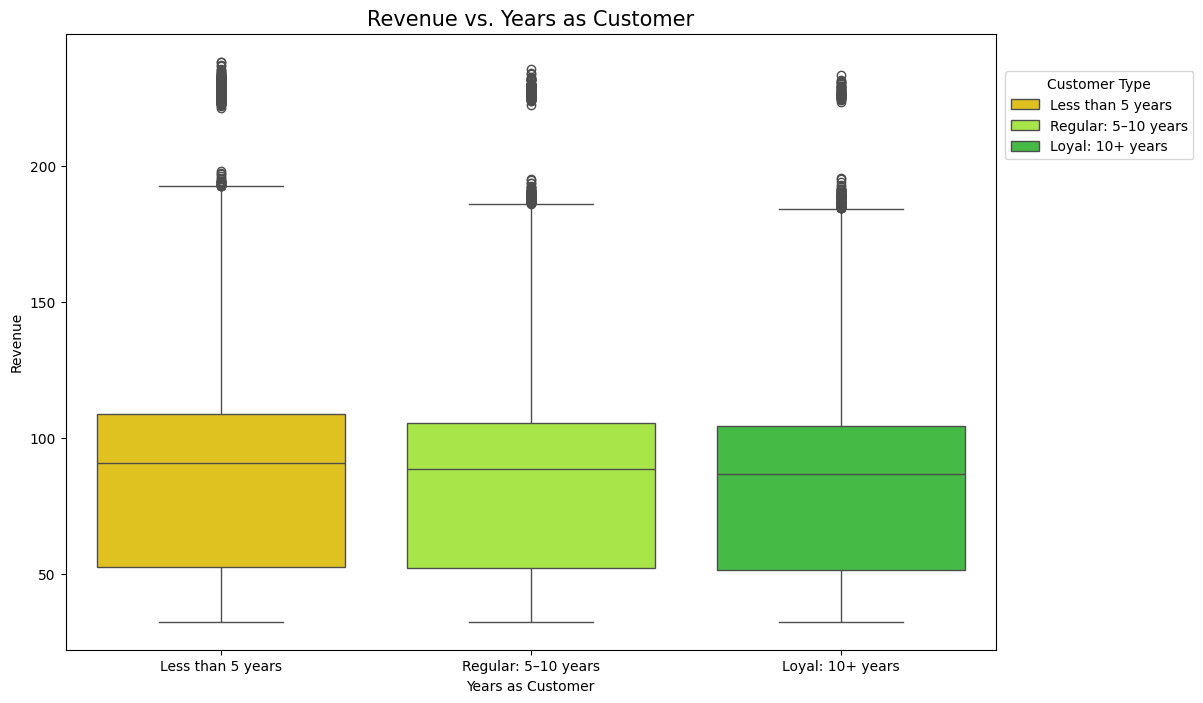

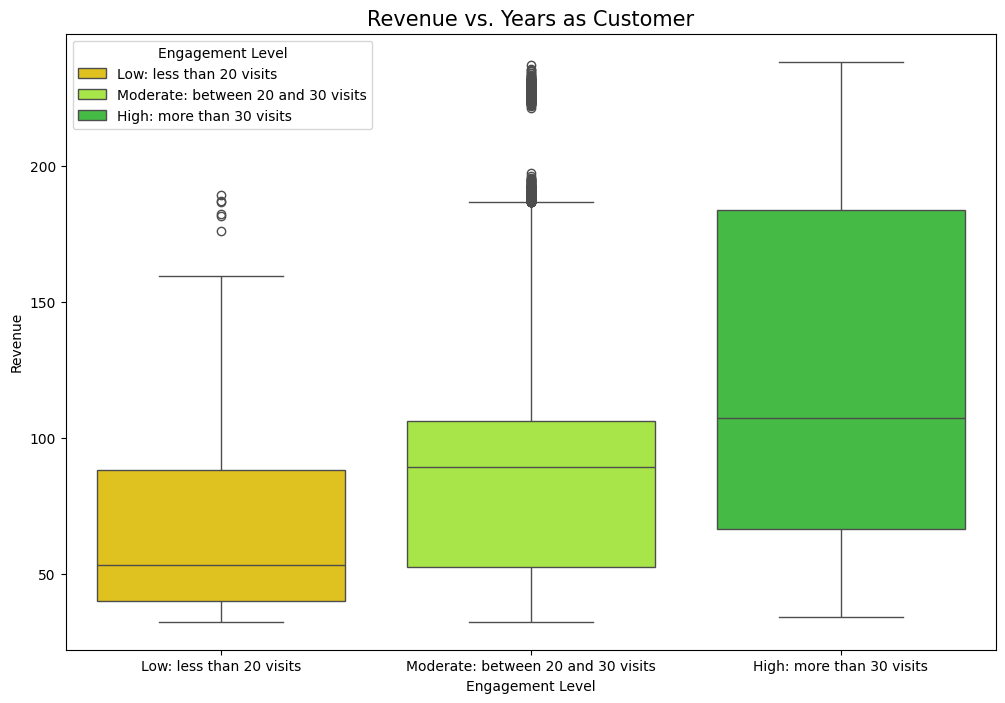

In [177]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_clean, x='customer_type', y='revenue', hue='customer_type', palette=custom_palette)
plt.title('Revenue vs. Years as Customer', fontsize=15)
plt.xlabel('Years as Customer')
plt.ylabel('Revenue')
plt.legend(title='Customer Type', loc='upper right', bbox_to_anchor = (1.22,0.95))
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_clean, x='engagement_level', y='revenue', hue='engagement_level', palette=custom_palette)
plt.title('Revenue vs. Years as Customer', fontsize=15)
plt.xlabel('Engagement Level')
plt.ylabel('Revenue')
plt.legend(title='Engagement Level')
plt.show()

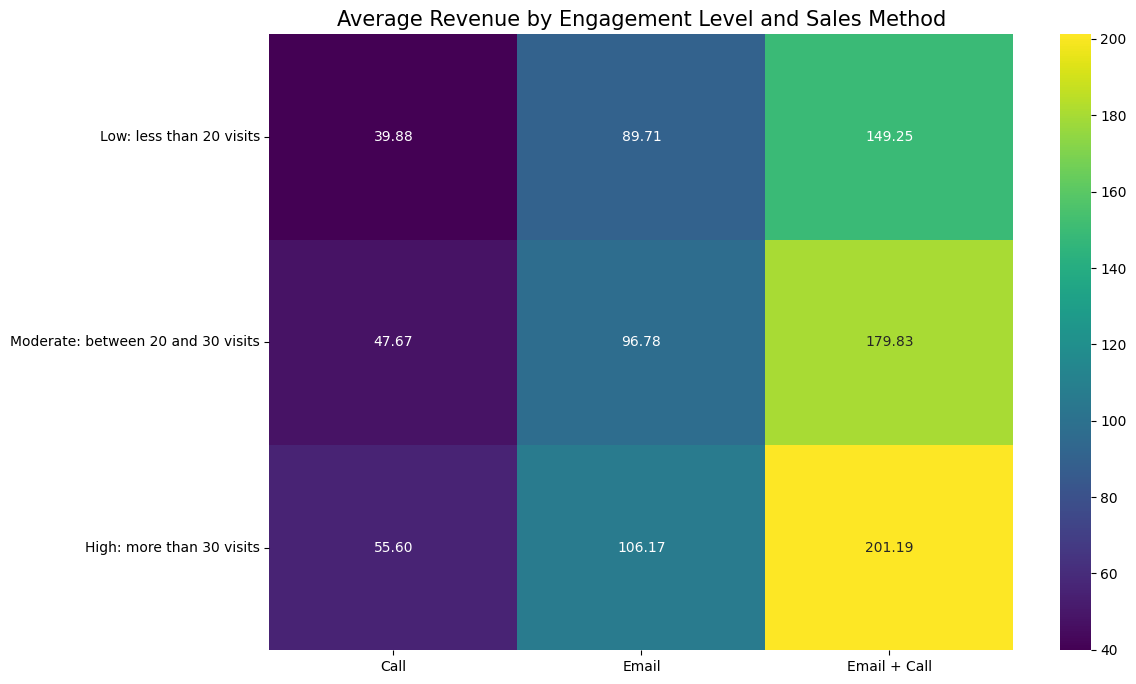

In [178]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean.groupby(['engagement_level', 'sales_method'], observed = True)['revenue'].mean().unstack(), cmap='viridis', annot=True, fmt='.2f')
plt.title('Average Revenue by Engagement Level and Sales Method', fontsize=15)
plt.xlabel('')
plt.ylabel('')
plt.show()

#### 5. Geographical Differences:
- Do different states show significant differences in revenue or sales methods?
- Are there particular regions (states) where one sales method is more effective than others?

**Insights**
- `California` (CA) leads in total revenue with $161,040.89, followed by `Texas` (TX) and New York (NY). This trend correlates with the large number of customers—1,739 in `California`, 1,109 in `Texas`, and 899 in New York—as well as higher engagement (e.g., site visits). The higher revenue and site visits suggest that these states are major markets.
- States like North and South Dakota, along with Delaware, have smaller customer bases (less than 100 customers) but exhibit higher revenue per customer, with North Dakota leading at $104.75 and South Dakota at $104.07. This indicates that customers in these states spend more on average, suggesting these high-value markets have significant growth potential if their customer bases can be expanded.
- `North` and `South` Dakota have the highest average revenue per customer, at $104.75 and $104.07, respectively, indicating that customers in these states spend more on average than those in other states.
- While `California` and  `Texas` generate higher total revenue, states like `North` and `South` Dakota have more lucrative customers on a per-customer basis.

- States like '`Dakota`' and `Delaware` have a smaller customer base (less than 100) but show a higher revenue per customer, indicating potential for further growth if the customer base could be expanded in these high-value markets.


- Most states have a **similar average site visit per customer** (around 25 visits), suggesting a consistent level of engagement across different regions. `Targeting states with high average revenue per customer` for specific growth strategies could increase profitability.

-Further analysis of the 15 states with the highest revenue reveals that the highest revenue figures are linked to the Email-only sales method, with `California` generating the highest revenue at $83,163.31. The `Email + Call` method shows strong performance in certain states, such as `California` ($48,133.97) and `Texas` ($34,823.26), but it does not reach the same revenue levels as the Email-only method. In terms of revenue per customer, the `Email + Call method` yields the highest return.


**Data Source** https://www.weather.gov/gis/USStates

**Shapefile Attributes**

| Field Name | Type       | Width, Dec | Description                      |
|------------|------------|------------|----------------------------------|
| STATE      | character  | 2          | State abbrev [aa]                |
| NAME       | character  | 24         | State name                       |
| FIPS       | character  | 2          | State FIPS Code [ss]             |
| LON        | numeric    | 10,5       | Longitude of centroid [decimal degrees] |
| LAT        | numeric    | 9,5        | Latitude of centroid [decimal degrees]  |




In [194]:
url = "./data/s_05mr24/s_05mr24.shp"
us_states = gpd.read_file(url)
us_states = us_states.to_crs(epsg=4326)
us_states = us_states[['STATE', 'NAME', 'geometry']]

df_states_revenue = df_clean.groupby('state', observed = True)[['revenue', 'nb_site_visits']].agg(revenue_sum=('revenue', 'sum'),
    revenue_mean=('revenue', 'mean'),
    visits_sum=('nb_site_visits', 'sum'),
    visits_mean=('nb_site_visits', 'mean'),
    num_of_customers =('revenue', 'size')).reset_index()
df_states_map = pd.merge(us_states, df_states_revenue, left_on='NAME', right_on='state', how='inner')

In [195]:
df_islands = df_states_map[df_states_map['STATE'].isin(['AK', 'HI', 'AS', 'GU', 'MP', 'VI', 'FM', 'MH', 'PW'])]
df_islands

,STATE,NAME,geometry,state,revenue_sum,revenue_mean,visits_sum,visits_mean,num_of_customers
9,HI,Hawaii,"MULTIPOLYGON (((-155.91184 19.18402, -155.912 ...",Hawaii,6525.65,97.397761,1673,24.970149,67
49,AK,Alaska,"MULTIPOLYGON (((-179.10754 51.30121, -179.1054...",Alaska,3199.99,91.428286,881,25.171429,35


In [197]:
mainland_us_states = df_states_map[~df_states_map['STATE'].isin(['AK', 'HI', 'AS', 'GU', 'MP', 'VI', 'FM', 'MH', 'PW'])]
top_15_states = df_states_map.sort_values(by="revenue_sum", ascending=False).head(15)
top_15_states

,STATE,NAME,geometry,state,revenue_sum,revenue_mean,visits_sum,visits_mean,num_of_customers
3,CA,California,"MULTIPOLYGON (((-118.4262 32.79973, -118.42634...",California,161040.89,92.605457,43288,24.892467,1739
38,TX,Texas,"MULTIPOLYGON (((-97.1997 25.99932, -97.19998 2...",Texas,106294.45,95.847115,27645,24.927863,1109
30,NY,New York,"MULTIPOLYGON (((-73.72681 40.59421, -73.72669 ...",New York,83242.74,92.594816,22444,24.965517,899
7,FL,Florida,"MULTIPOLYGON (((-81.96339 24.5211, -81.96374 2...",Florida,77651.75,94.009383,20816,25.200969,826
12,IL,Illinois,"POLYGON ((-90.64 42.50841, -90.6366 42.50831, ...",Illinois,52649.35,91.405122,14308,24.840278,576
34,PA,Pennsylvania,"MULTIPOLYGON (((-79.7622 42.26891, -79.762 42....",Pennsylvania,51595.35,93.300814,13804,24.962025,553
31,OH,Ohio,"MULTIPOLYGON (((-82.65704 41.43713, -82.6574 4...",Ohio,48010.94,92.328731,12950,24.903846,520
19,MI,Michigan,"MULTIPOLYGON (((-83.43458 41.73714, -83.43464 ...",Michigan,44424.81,95.332210,11599,24.890558,466
8,GA,Georgia,"MULTIPOLYGON (((-81.49619 30.73234, -81.49648 ...",Georgia,43426.41,94.405239,11459,24.910870,460
23,NC,North Carolina,"MULTIPOLYGON (((-77.50814 34.45068, -77.50844 ...",North Carolina,38418.15,89.344535,10582,24.609302,430


In [205]:
top_15_states_avg = df_states_map.sort_values(by="revenue_mean", ascending=False).head(15)
top_15_states_avg

,STATE,NAME,geometry,state,revenue_sum,revenue_mean,visits_sum,visits_mean,num_of_customers
36,SD,South Dakota,"POLYGON ((-102.64259 45.94541, -102.6384 45.94...",South Dakota,3980.69,104.755000,959,25.236842,38
24,ND,North Dakota,"POLYGON ((-97.2327 48.99921, -97.2339 48.99671...",North Dakota,2601.93,104.077200,612,24.480000,25
6,DE,Delaware,"MULTIPOLYGON (((-75.22731 38.58854, -75.22744 ...",Delaware,2780.82,102.993333,656,24.296296,27
11,ID,Idaho,"POLYGON ((-116.06 49.00081, -116.04919 49.0002...",Idaho,6024.39,102.108305,1481,25.101695,59
41,VT,Vermont,"POLYGON ((-72.8321 45.01641, -72.8257 45.01631...",Vermont,2747.43,101.756667,649,24.037037,27
21,MS,Mississippi,"MULTIPOLYGON (((-88.62128 30.35913, -88.62421 ...",Mississippi,13349.49,100.372105,3315,24.924812,133
47,SC,South Carolina,"MULTIPOLYGON (((-82.38064 35.20132, -82.37949 ...",South Carolina,21344.17,100.207371,5361,25.169014,213
44,WV,West Virginia,"POLYGON ((-80.5202 40.63791, -80.519 40.63431,...",West Virginia,7701.99,100.025844,1966,25.532468,77
39,UT,Utah,"POLYGON ((-111.04929 42.00161, -111.0468 42.00...",Utah,11440.50,99.482609,2920,25.391304,115
29,NV,Nevada,"POLYGON ((-114.8162 42.00201, -114.809 42.0018...",Nevada,9587.55,98.840722,2409,24.835052,97


C:\Users\User\AppData\Local\Temp\ipykernel_16832\3761109998.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(top_15_states.geometry.centroid.x, top_15_states.geometry.centroid.y, top_15_states['revenue_sum']):


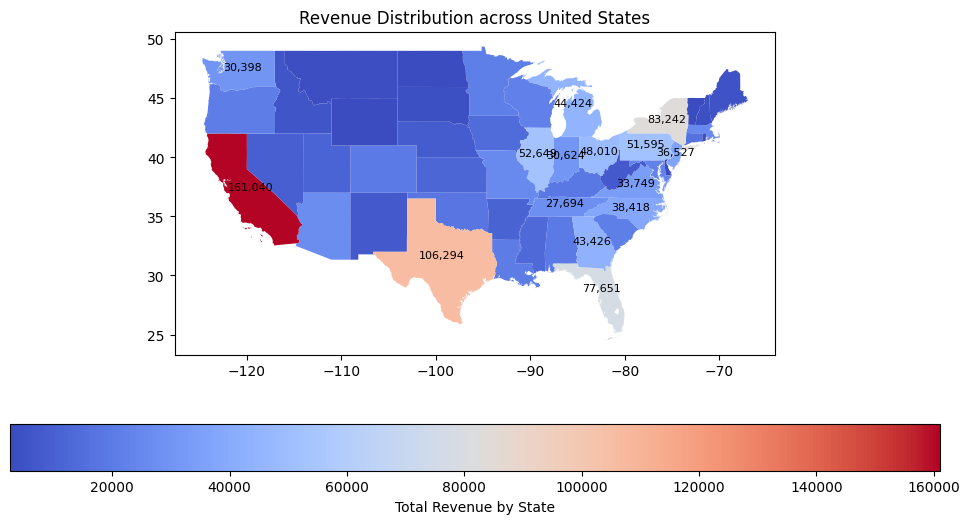

In [202]:
# Plot the mainland US states

fig, ax = plt.subplots(figsize=(12, 6))
mainland_us_states.plot(column = 'revenue_sum', ax=ax,  legend=True, 
               legend_kwds={'label': "Total Revenue by State", 
                            'orientation': "horizontal"},
               cmap='coolwarm')
plt.title('Revenue Distribution across United States')
for x, y, label in zip(top_15_states.geometry.centroid.x, top_15_states.geometry.centroid.y, top_15_states['revenue_sum']):
    ax.text(x, y, f"{int(label):,}" if label>5 else '', fontsize=8, ha='center', color='black')
plt.show()



C:\Users\User\AppData\Local\Temp\ipykernel_16832\2001330986.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(mainland_us_states.geometry.centroid.x, mainland_us_states.geometry.centroid.y, mainland_us_states['revenue_mean']):


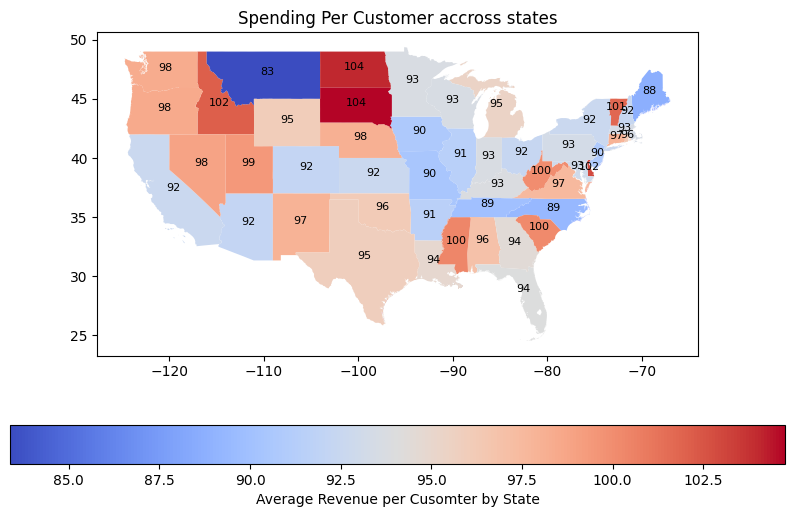

In [208]:
# Plot the mainland US states

fig, ax = plt.subplots(figsize=(10, 6))
mainland_us_states.plot(column = 'revenue_mean', ax=ax,  legend=True, 
               legend_kwds={'label': "Average Revenue per Cusomter by State", 
                            'orientation': "horizontal"},
               cmap='coolwarm')
plt.title('Spending Per Customer accross states')
for x, y, label in zip(mainland_us_states.geometry.centroid.x, mainland_us_states.geometry.centroid.y, mainland_us_states['revenue_mean']):
    ax.text(x, y, f"{int(label):,}" if label>5 else '', fontsize=8, ha='center', color='black')
plt.show()

# Show the map
plt.show()

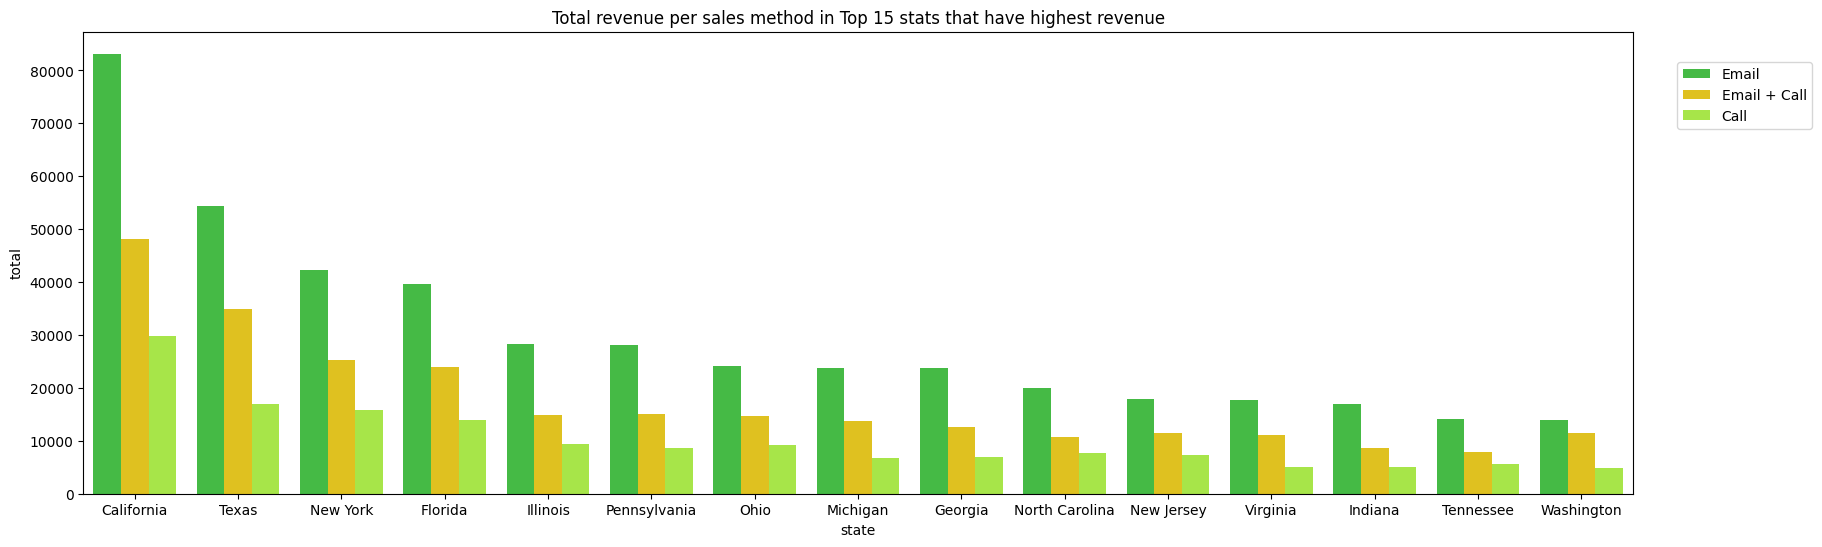

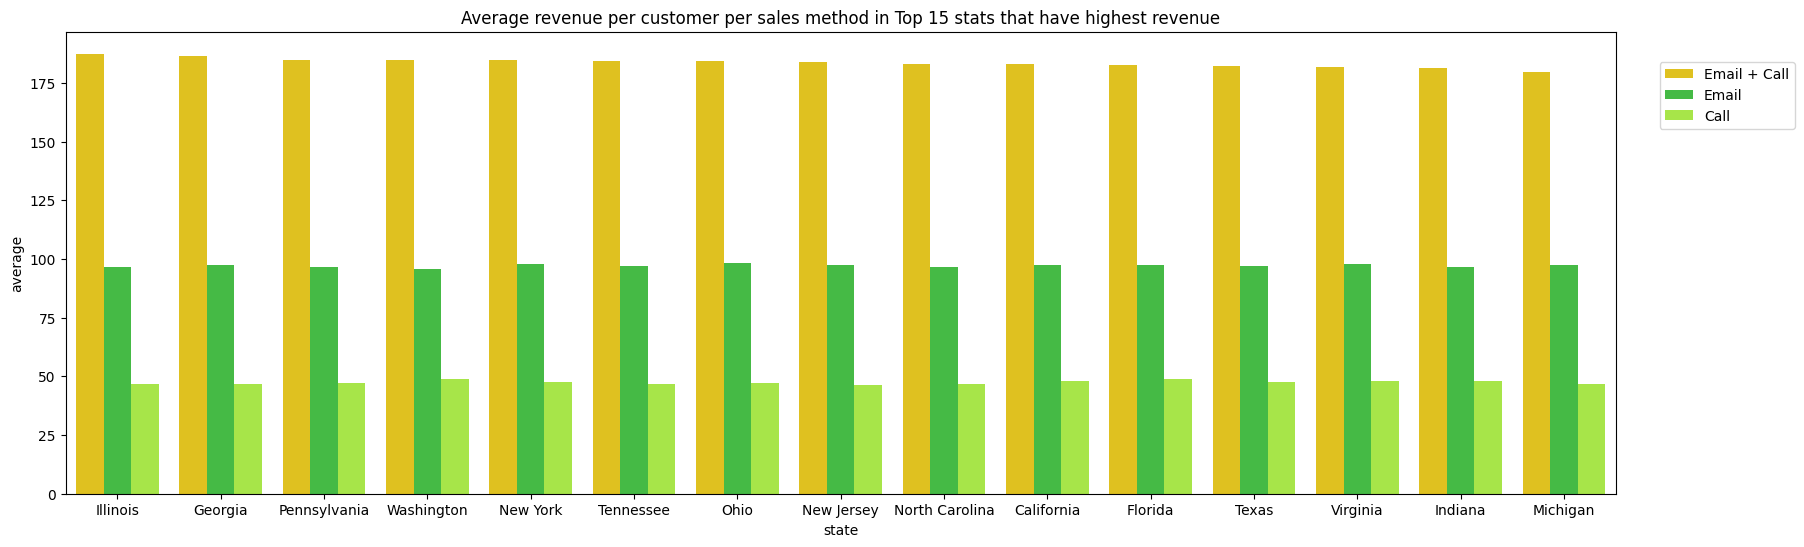

In [228]:
top_15_states_list = list(top_15_states['NAME'].unique())
df_top_15_states = df_clean[df_clean['state'].isin(top_15_states_list)]

top_15_states_sales = df_top_15_states.groupby(['state', 'sales_method'])['revenue'].agg(total = 'sum', average = 'mean').reset_index()
top_15_states_sales = top_15_states_sales.sort_values(by='total', ascending = False)
#top_15_states_sales['sales_method'] = pd.Categorical(top_15_states_sales['sales_method'],categories= color_code.keys(), ordered=True)
sales_method_order = top_15_states_sales['sales_method'].unique()
colr_order = [color_code[method] for method in sales_method_order]

plt.figure(figsize = (20,6))
sns.barplot(data = top_15_states_sales, x = 'state', hue = 'sales_method', y = 'total', errorbar=None,palette=colr_order)
plt.legend(loc='upper right', bbox_to_anchor=(1.12,0.95))
plt.title("Total revenue per sales method in Top 15 stats that have highest revenue")
plt.show()


top_15_states_sales = top_15_states_sales.sort_values(by='average', ascending = False)
sales_method_order = top_15_states_sales['sales_method'].unique()
colr_order = [color_code[method] for method in sales_method_order]
plt.figure(figsize = (20,6))
sns.barplot(data = top_15_states_sales, x = 'state', hue = 'sales_method', y = 'average', errorbar=None,palette=colr_order)
plt.legend(loc='upper right', bbox_to_anchor=(1.12,0.95))
plt.title("Average revenue per customer per sales method in Top 15 stats that have highest revenue")
plt.show()




In [230]:
top_15_states_sales = df_top_15_states.groupby(['state', 'sales_method'])['revenue'].agg(total = 'sum', average = 'mean').reset_index()
top_15_states_sales

,state,sales_method,total,average
0,California,Call,29743.61,47.896312
1,California,Email,83163.31,97.267029
2,California,Email + Call,48133.97,183.018897
3,Florida,Call,13999.89,48.780105
4,Florida,Email,39727.98,97.372500
5,Florida,Email + Call,23923.88,182.625038
6,Georgia,Call,6927.05,46.804392
7,Georgia,Email,23812.00,97.590164
8,Georgia,Email + Call,12687.36,186.578824
9,Illinois,Call,9462.50,46.613300


#### 7. Recommendation for Future Sales Methods:
- Based on the findings, which sales method would you recommend continuing, and why?
- If two or more methods yield similar results in terms of revenue, would it make sense to prioritize the more efficient method (i.e., the one that requires less team time)?